In [109]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne_nirs.statistics import statsmodels_to_results

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mne_nirs.statistics import run_glm
import matplotlib as mpl
from mne.stats import fdr_correction


# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [110]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 50

# Time from trigger point being evaluated
tmin = -1
tmax = 50

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False





In [111]:
# FV Study Parameters
ignore = [".DS_Store", ".git", "sub-18", "sub-14", ".gitignore"]
columns_for_group_analysis = ['Neutral', 'Concern']
columns_for_glm_contrast = ['Neutral', 'Concern']
path = '../../FV_Prelim_Data/'
trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}
columns_for_fdr = ['Neutral', 'Concern']


In [112]:
# # FA Study Parameters
# columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']
# columns_for_glm_contrast = ['Neutral', 'Inflam', 'Control']
# columns_for_fdr = ['Control', 'Inflam']
# path = "../../LabResearch/IndependentStudy/Data/FA"
# ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}

In [113]:
# Oculus Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/oculus_montage_bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [114]:
# N-Back Control Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/n-back-bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [115]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)
        
        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        
        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        raw_haemo = all_data[0]['raw_haemo']
        
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [116]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        
        raw_haemo = all_data[0]['raw_haemo']

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [117]:
importlib.reload(glm_analysis)
group_data, all_epochs, all_evokeds, glm_results = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=tmin, tmax=tmax, trigger_id=trigger_id)

print(glm_results)


Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-13/nirs/2023-03-09_001.snirf
Reading 0 ... 9146  =      0.000 ...   899.052 secs...
Events {'Concern': 1, 'Neutral': 2, 'Start': 3} ../../FV_Prelim_Data//all_groups/sub-13/nirs/2023-03-09_001.snirf
sub_id 13
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-15/nirs/2023-03-22_005.snirf
Reading 0 ... 8796  =      0.000 ...   864.647 secs...
Events {'Concern': 1, 'Neutral': 2, 'Start': 3} ../../FV_Prelim_Data//all_groups/sub-15/nirs/2023-03-22_005.snirf
sub_id 15
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all_groups/sub-12/nirs/2023-02-10_003.snirf
Reading 0 ... 8750  =      0.000 ...   860.125 secs...
Events {'Concern': 1, 'Neutral': 2, 'Start': 3} ../../FV_Prelim_Data//all_groups/sub-12/nirs/2023-02-10_003.snirf
sub_id 12
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../FV_Prelim_Data/all

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


GLM Results for 36 channels


/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:296: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:296: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df)


In [118]:
# individual_data, all_epochs, all_evokeds = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, trigger_id)
# individual_data

# Visualizations

Index(['Condition', 'df', 'mse', 'p_value', 'se', 't', 'theta', 'Source',
       'Detector', 'Chroma', 'Significant', 'ch_name', 'ID'],
      dtype='object', name='variable')


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[vals] = model_data[vals].astype(float)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

[]
[]


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[vals] = model_data[vals].astype(float)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

[]
[]


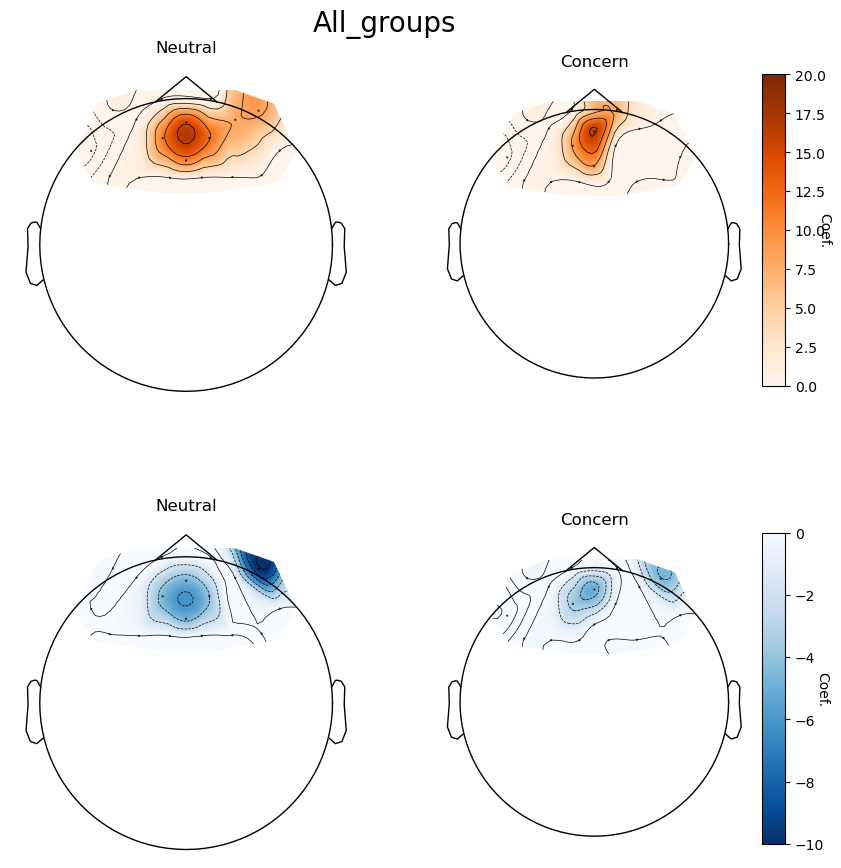

In [119]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()
    print(channels_df.columns)
    raw_haemo = all_data[0]['raw_haemo']
    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo, group)

LinAlgError: Singular matrix

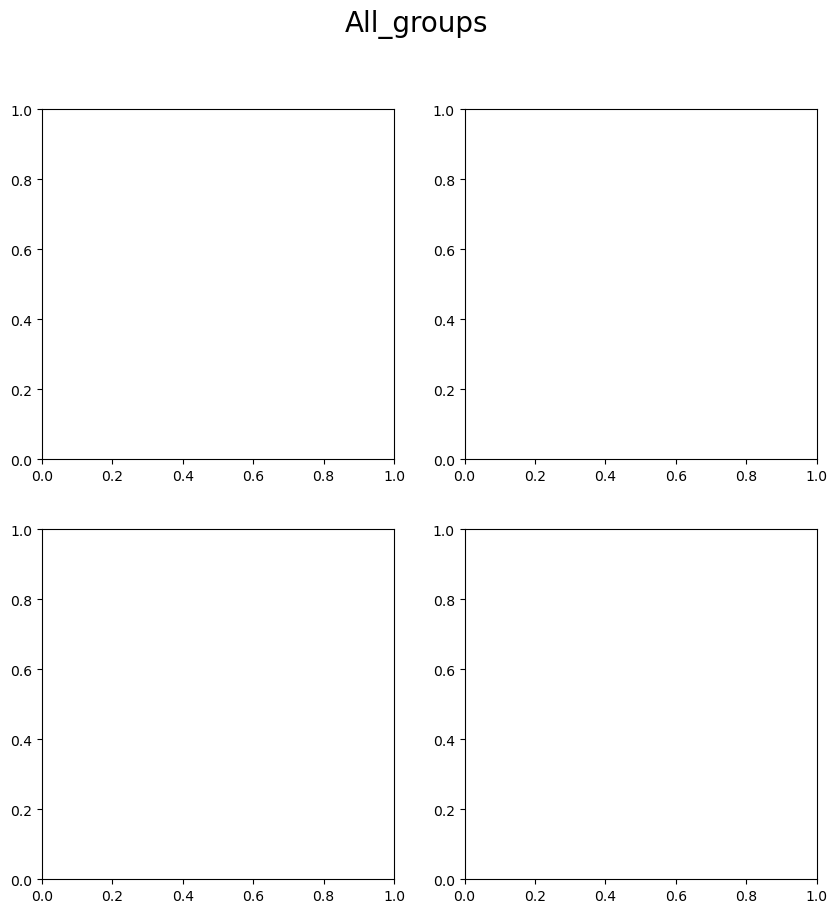

In [120]:
# Group Visualization with FDR Correction
importlib.reload(visualizations)
importlib.reload(analysis_tools)
ignored_vals = ['drift', 'Start', 'constant']

groups = list(group_data.keys())
results = {}
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

    channels_df_fdr = analysis_tools.false_discovery_rate_correction(channels_df, ignored_vals, columns_for_fdr)

    raw_haemo = all_data[0]['raw_haemo']

    # TRYING BUILT IN FDR FUNCTION
    alpha = 0.05
    p_vals = channels_df['p_value']
    reject_fdr, pval_fdr = fdr_correction(p_vals, alpha=alpha, method='indep')
    channels_df['fdr_status'] = reject_fdr
    channels_df_fdr = channels_df.loc[(channels_df['fdr_status'] == True) & (~channels_df['Condition'].isin(ignored_vals))]
    
    channels_df_fdr.to_csv('channels_df_fdr.csv')
    visualizations.group_topological_visualisation(channels_df_fdr, columns_for_glm_contrast, raw_haemo, group)

In [ ]:
# # Group Cortical Projections
# importlib.reload(visualizations)
# groups = list(group_data.keys())
# for group in groups:
#     # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
#     channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

#     raw_haemo = all_data[0]['raw_haemo']
#     visualizations.group_cortical_surface_projection(channels_df, columns_for_glm_contrast, raw_haemo, path)

In [ ]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, interval_length, variable_epoch_time)

RuntimeError('Waveform Analysis is not possible with variable length tasks')

In [ ]:
# Individual Visualization
# importlib.reload(visualizations)
# if individual_data:
#     channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

#     raw_haemo = all_data[0]['raw_haemo']

#     visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

# Export Results

In [ ]:
# Download the Results
keys = list(group_data.keys())
complete_results = pd.DataFrame()
for key in keys:
    sig_cha = group_data[key]['significant_channels']
    sig_cha['group'] = key
    complete_results = pd.concat([complete_results, sig_cha])
    complete_results['Coef.'] = complete_results['Coef.'] * 1e6
complete_results.to_csv('oculus_significant_channels.csv')